In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
torch.set_num_threads(1)
import matplotlib.pyplot as plt
import numpy as np
import random
SEED = 1
from sklearn.model_selection import StratifiedKFold

from Utils import EarlyStopping
from Models import   Contrastive_CB3, MertashBiParametricNetworkV3, CB1_BiRe1, CB1_BiRe1_int1, CB1_noSPD, CB1_BiRe1_int2, MertashBiParametricNetwork_WithOutBire
from Models import CB2_BiRe1, CB2_noSPD, CB2_BiRe1_int1, CB2_BiRe1_int2, CB3_BiRe1, CB3_noSPD, CB3_BiRe1_int1, CB3_BiRe1_int2
from ProstatexDataset import ProstatexDataset
from DatasetManagement import DatasetManagement
from Losses import SupervisedContrastiveLoss, NTXentLoss, TripletLoss
import json
import pandas as pd
import joblib
# device = torch.device('cpu')
# device = torch.device('cuda:0')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cpu = torch.device('cpu')
#'1.3.4' pandas version
def reset_random_seeds():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
%load_ext autoreload
%autoreload 2

In [2]:
def get_mining_config(args):
    if args['loss_function']['mining']['positives'] is None or args['loss_function']['mining']['negatives'] is None:
        return 'no-mining'
    else:
        rules = {
            'easy': 'e',
            'hard': 'h',
            'semihard': 'sh'
        }
        mining_name ='{}p-{}n'.format(
            rules[args['loss_function']['mining']['positives']],
            rules[args['loss_function']['mining']['negatives']]
        )
        return mining_name

def get_loss_function(args):
    if args['loss_function']['kind'] == 'TripletLoss':
        loss_name = '{}_ts_ephn_m_{}'.format(
            args['loss_function']['kind'],
            args['loss_function']['margin']
        )
    elif args['loss_function']['kind'] == 'n_pair':
        loss_name = args['loss_function']['kind']

    elif args['loss_function']['kind'] == 'NTXentLoss':
        loss_name = '{}_T_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['temperature']
        )
    
    elif args['loss_function']['kind'] == 'SupervisedContrastiveLoss':
        loss_name = '{}_T_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['temperature']
        )

    elif args['loss_function']['kind'] == 'max_margin':
        loss_name = '{}_met_{}_mar_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['metric'],
            args['loss_function']['margin']
        )

    return loss_name

def get_optimizer(args):
    if args['optimizer']['kind'] == 'RMSprop':
        optimizer_name = '{}_mom_{}_lr_{}'.format(
            args['optimizer']['kind'],
            args['optimizer']['momentum'],
            args['optimizer']['learning_rate']
        )
    elif args['optimizer']['kind'] == 'Adam':
        optimizer_name = '{}_lr_{}'.format(
            args['optimizer']['kind'],
            args['optimizer']['learning_rate']
        )
    return optimizer_name
    

In [3]:
def fit_contrastive(model, train_data, val_data, args):
    
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=args['epochs']*0.05)
    
    if args['loss_function']['kind'] == 'NTXentLoss':
        criterion = NTXentLoss(
            temperature = args['loss_function']['temperature'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
    elif args['loss_function']['kind'] == 'TripletLoss':
        criterion = TripletLoss(
            margin=args['loss_function']['margin'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
        
    elif args['loss_function']['kind'] == 'SupervisedContrastiveLoss':
        criterion = SupervisedContrastiveLoss(
            temperature=args['loss_function']['temperature'],
        )
    
    if args['optimizer']['kind'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args['optimizer']['learning_rate'])
    elif args['optimizer']['kind'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(
            model.parameters(), 
            lr=args['optimizer']['learning_rate'],
            momentum = args['optimizer']['momentum']
        )
    train_loader = torch.utils.data.DataLoader(
        dataset = train_data,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )
    val_loader = torch.utils.data.DataLoader(
        dataset = val_data,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )
    
    #train_loop
    model.train()
    model.to(device)
    model.type(torch.double)
    for epoch in range (args['epochs']):
        if early_stopping.early_stop:
            break;
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            for j in range(len(inputs)):
                inputs[j] = inputs[j].to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            outputs = torch.nn.functional.normalize(outputs, p=2.0) ## acá es la normalizada la cual ya está en el espacio de contrastivo?
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()* inputs[0].size(0)
        
        running_loss = running_loss / len(train_data)
        train_losses.append(running_loss) #VOY ACÁAAAAAAAAAAAAA
        with torch.no_grad():
            #validation_loop
            model.eval()
            model.to(device)
            val_loss = 0.0
            for i, data in enumerate(val_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                for j in range(len(inputs)):
                    inputs[j] = inputs[j].to(device)
                labels = labels.to(device)
                # forward + backward + optimize
                outputs = model(inputs)
                outputs = torch.nn.functional.normalize(outputs, p=2.0)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs[0].size(0)
            val_loss = val_loss / len(val_data)
            val_losses.append(val_loss)

            early_stopping(val_loss)
            if (epoch+1) % 1 == 0: #25
                print('Epoch {}, val_loss:{:.3f}, train_loss:{:.3f}'.format(epoch+1, val_loss, running_loss ))
        
        
    return {
        'loss': train_losses,
        'val_loss': val_losses,
    }

In [4]:
def fit_linear_top(model, train_data):
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    
    logistic_regressor = LogisticRegression(random_state=SEED)
    svm = SVC(kernel='linear', probability=True, random_state= SEED)
    train_loader = torch.utils.data.DataLoader(
        dataset = train_data,
        shuffle = False,
        batch_size = len(train_data),
        pin_memory=False
    )
    with torch.no_grad():
        #train_loop
        model.train()
        model.to(cpu)
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)
            outputs = torch.nn.functional.normalize(outputs, p=2.0)
            labels = torch.squeeze(labels, dim=1)
            logistic_regressor.fit(outputs.numpy(), labels.numpy())
            svm.fit(outputs.numpy(), labels.numpy())
            print("labels shape", labels.shape)
            
    print('finished linear training')
    return {
        'svm': svm, 
        'logistic_regression': logistic_regressor
    }
    

In [5]:
def evaluate(model, classifiers, test_data):
    import joblib
    
    
    
    svm = classifiers['svm']
    logistic_regressor = classifiers['logistic_regression']
    train_loader = torch.utils.data.DataLoader(
        dataset = test_data,
        shuffle = False,
        batch_size = len(test_data),
        pin_memory=False
    )
    with torch.no_grad():
        #train_loop
        model.eval()
        model.to(cpu)
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)
            outputs = torch.nn.functional.normalize(outputs, p=2.0)
            #labels = torch.squeeze(labels, dim=1)
            print("labels shape", labels.shape)
            print("embeddings shape", outputs.shape)
            lr_probs = logistic_regressor.predict_proba(outputs.numpy())[:,1]
            svm_probs = svm.predict_proba(outputs.numpy())[:,1]
            
            
    print('finished linear training')
    return {
        'svm_probs': svm_probs, 
        'lr_probs': lr_probs
    }
    

In [6]:
def get_fold_of_data(kfold_number):

    #FOLD_IDEX_PATH = '/home/churtado26/Data/PICAI/PICAI/picai_folds_indexes.json'
    FOLD_IDEX_PATH = '/home/camedu/Data/cesar/picai_folds_indexes.json'

    fold_indexes = open(FOLD_IDEX_PATH, 'r')
    indexdes = json.load(fold_indexes)
    #indexdes.keys()

    training_target_kfold = 'Fold_{}_train'.format(kfold_number)
    validation_target_kfold = 'Fold_{}_val'.format(kfold_number)


    # REVISAR EL PSA EN EL JSON!!
    #BASE_PATH = '/home/churtado26/Data/PICAI/PICAI/patches/'
    BASE_PATH = '/home/camedu/Data/cesar/'
    JSON_PATH = os.path.join(BASE_PATH, 'info-12x32x32.json')
    IMAGES_PATH = os.path.join(BASE_PATH, 'size-12x32x32')
    file = open(JSON_PATH, 'r')

    metadata = json.load(file)
    file_names = os.listdir(IMAGES_PATH)


    X_train = []
    Y_train = []
    
    ids_train = []
    ids_val = []

    X_validation = []
    Y_validation = []



    for patient_id in indexdes[training_target_kfold]:
        file_name = '{}.npy'.format(patient_id)
        img = np.load(os.path.join(IMAGES_PATH, file_name))
        X_train.append(img)
        ids_train.append(patient_id)

        y = metadata[patient_id]['label']
        Y_train.append(y)

    for patient_id in indexdes[validation_target_kfold]:
        file_name = '{}.npy'.format(patient_id)
        img = np.load(os.path.join(IMAGES_PATH, file_name))
        X_validation.append(img)
        ids_val.append(patient_id)

        y = metadata[patient_id]['label']
        Y_validation.append(y)
        
    return np.array(X_train), np.array(X_validation), np.array(Y_train), np.array(Y_validation), ids_train, ids_val




In [7]:
def run_k_fold(args):
    current_fold = 0
    optimizer_name = get_optimizer(args)
    mining_name = get_mining_config(args)   
    #base_path = '/home/churtado26/Data/contrastive/Experiments/'
    base_path = '/home/camedu/Data/cesar/'
    
    for fold_number in range(0,5):
            current_fold += 1

            x_train, x_validation ,y_train, y_validation, ids_train, ids_val = get_fold_of_data(fold_number)
            train_dataset = DatasetManagement(x_train, y_train)
            val_dataset = DatasetManagement(x_validation, y_validation)
            test_dataset = val_dataset
            Contrastive_CB3
            
            size = x_train.nbytes 
            print(f"Tamaño del np del error: {size}")
            correct_fold_list = []
            del x_train, x_validation, y_train, y_validation
            for i in range (len(ids_val)):
                correct_fold_list.append('test')
                    

            
            if args['backbone_name'] == 'MertashBiParametricNetworkV3':
                model = MertashBiParametricNetworkV3(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded MertashBiParametricNetworkV3 model')
                
            if args['backbone_name'] == 'Contrastive_CB3':
                model = Contrastive_CB3(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded Contrastive_CB3 model')
                
            if args['backbone_name'] == 'MertashBiParametricNetwork_WithOutBire':
                model = MertashBiParametricNetwork_WithOutBire(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded MertashBiParametricNetwork_WithOutBire model')
                
                
            history = fit_contrastive(model, train_dataset, val_dataset, args)
            plt.plot(history['loss'], label = 'loss')
            plt.plot(history['val_loss'], label = 'val_loss')
            plt.legend()
            plt.show()
            classifiers = fit_linear_top(model, train_dataset)
            probs = evaluate(model, classifiers, test_dataset)
            
            joblib.dump(
                classifiers['svm'],
                base_path+'models/svm_fold_{}.pkl'.format(current_fold)
            )
            joblib.dump(
                classifiers['logistic_regression'],
                base_path+'models/lr_fold_{}.pkl'.format(current_fold)
            )
#             print(len(ids_train)) #1035
#             print(len(ids_val))#260
#             print(len(all_idx))#1295
#             print(len(correct_fold_list))#1295
#             print(len(y_validation))#260
#             print(len(probs['lr_probs'].tolist()))#260
#             print(len(probs['svm_probs'].tolist()))#260
            
            
            kfold_dataframe = pd.DataFrame(
                {
                 'indexes': ids_val,
                 'folds': correct_fold_list,   
                 'labels': y_validation.tolist(),
                 'lr_probs': probs['lr_probs'].tolist(),
                 'svm_probs': probs['svm_probs'].tolist()
                }
            )
            kfold_dataframe.to_csv('{}/results/kfold_results_{}.csv'.format(base_path, current_fold))            
            
            directory = os.path.join(base_path, 'models')
            if not os.path.exists(directory):
                os.makedirs(directory)
            
            torch.save(                
                model.state_dict(), 
                base_path+'models/mertash_contrastive_fold_{}.pt'.format(current_fold)
                )
            
#             kfold_dataframe = pd.DataFrame(
#                 {
#                  'labels': y_validation.tolist(),
#                  'lr_probs': probs['lr_probs'].tolist(),
#                  'svm_probs': probs['svm_probs'].tolist()
#                 }
#             )
#             kfold_dataframe.to_csv('{}/results/kfold_results_{}.csv'.format(base_path, fold_number))

Tamaño del np del error: 305233920
loaded Contrastive_CB3 model
Epoch 1, val_loss:0.670, train_loss:0.304
Epoch 2, val_loss:0.466, train_loss:0.437
INFO: Early stopping
Epoch 3, val_loss:0.503, train_loss:0.317


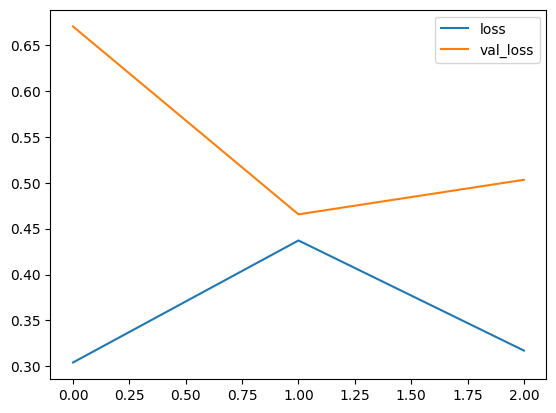

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 21976842240 bytes. Error code 12 (Cannot allocate memory)

In [8]:
args = {
                        'subsampling_strategy':{
                            'name': 'subsampling_criteria',
                            'percentage': 'train_data_percentage'
                        },
                        'optimizer':{
                            'kind': 'RMSprop',
                            'learning_rate': 1e-6,
                            'momentum': 0.6
                        },
                        'loss_function': {
                                'kind': 'NTXentLoss',
                                'temperature': 0.07,
                                'mining': {
                                    'positives': 'easy',
                                    'negatives': 'semihard'
                                }
                        },
                        'number_folds': 5,
                        'backbone_name': 'Contrastive_CB3',
                        'data': 'mertash',
                        'sequence_embedding_features': 18432,
                        'target_shape': (12, 32, 32),
                        'batch_size': 32,
                        'epochs': 10,
                    }
run_k_fold(args)

In [11]:
# for subsampling_criteria in ['stratified', 'reduce_negatives', 'reduce_positives', ]:
#     for percentage in [20, 40, 60, 80, 100]:
#         train_data_percentage = percentage / 100
#         args = {
#                                 'subsampling_strategy':{
#                                     'name': subsampling_criteria,
#                                     'percentage': train_data_percentage
#                                 },
#                                 'optimizer':{
#                                     'kind': 'RMSprop',
#                                     'learning_rate': 1e-6,
#                                     'momentum': 0.6
#                                 },
#                                 'loss_function': {
#                                         'kind': 'NTXentLoss',
#                                         'temperature': 0.07,
#                                         'mining': {
#                                             'positives': None,
#                                             'negatives': None
#                                         }
#                                 },
#                                 'number_folds': 5,
#                                 'backbone_name': 'MertashMultiParametricNetworkV2',
#                                 'data': 'mertash',
#                                 'sequence_embedding_features': 512,
#                                 'target_shape': (12, 32, 32),
#                                 'batch_size': 32,
#                                 'epochs': 5000,
#                             }
#         run_k_fold(args)

# VISUALIZANDO EMBEBIDOS

In [23]:
weights_path = '/home/churtado26/Data/contrastive/Experiments/models/mertash_contrastive_fold_5.pt'
weights = torch.load(weights_path)
model = MertashBiParametricNetworkV3(args['target_shape'], args['sequence_embedding_features'], 'contrastive')
model.load_state_dict(weights)

<All keys matched successfully>

In [71]:
import numpy as np

x_val_all_0 = []
x_val_all_1 = []
y_val_all_0 = []
y_val_all_1 = []

for fold_number in range(5):
    x_train, x_val, y_train, y_val, ids_train, ids_val = get_fold_of_data(fold_number)
    
    # Crea una máscara booleana para cada clase
    mask_0 = (y_val == 0)
    mask_1 = (y_val == 1)
    
    # Usa la máscara para separar los datos de cada clase
    x_val_all_0.append(x_val[mask_0])
    x_val_all_1.append(x_val[mask_1])
    y_val_all_0.append(y_val[mask_0])
    y_val_all_1.append(y_val[mask_1])

# Concatena los datos de todos los folds para cada clase
x_val_all_0 = np.concatenate(x_val_all_0, axis=0)
x_val_all_1 = np.concatenate(x_val_all_1, axis=0)
y_val_all_0 = np.concatenate(y_val_all_0, axis=0)
y_val_all_1 = np.concatenate(y_val_all_1, axis=0)

# Ahora puedes crear tus DatasetManagement con los datos de validación de cada clase
val_data_0 = DatasetManagement(x_val_all_0, y_val_all_0)
val_data_1 = DatasetManagement(x_val_all_1, y_val_all_1)


In [86]:
    val_loader0 = torch.utils.data.DataLoader(
        dataset = val_data_0,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )

In [114]:

with torch.no_grad():
    #validation_loop
    model.eval()
    model.to(device)
    val_loss = 0.0
    for i, data in enumerate(val_loader0, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        for j in range(len(inputs)):
            inputs[j] = inputs[j].to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs_0 = model(inputs)
        outputs_0 = torch.nn.functional.normalize(outputs_0, p=2.0)

In [115]:
outputs_0.size()

torch.Size([19, 128])

In [88]:
import umap

reducer = umap.UMAP(n_components=2)
vectores_2d_0 = reducer.fit_transform(outputs_0.detach().cpu().numpy())


--------------------------------------

In [89]:
    val_loader1 = torch.utils.data.DataLoader(
        dataset = val_data_1,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )

In [116]:

with torch.no_grad():
    #validation_loop
    model.eval()
    model.to(device)
    val_loss = 0.0
    for i, data in enumerate(val_loader1, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        for j in range(len(inputs)):
            inputs[j] = inputs[j].to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs_1 = model(inputs)
        outputs_1 = torch.nn.functional.normalize(outputs_1, p=2.0)

In [117]:
import umap

reducer = umap.UMAP(n_components=2)
vectores_2d_1 = reducer.fit_transform(outputs_1.detach().cpu().numpy())


In [118]:
vectores_2d_1.size

56

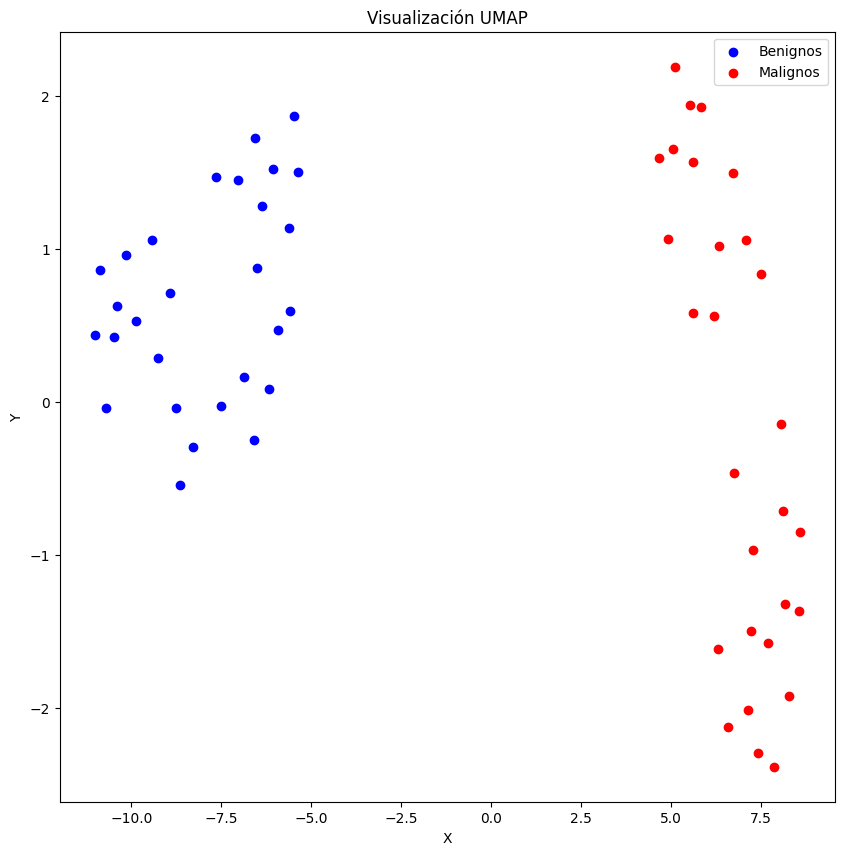

In [107]:
import matplotlib.pyplot as plt

# Asume que 'vectores_2d_0' y 'vectores_2d_1' son tus vectores bidimensionales de cada clase
plt.figure(figsize=(10, 10))
plt.scatter(vectores_2d_0[:, 0], vectores_2d_0[:, 1], c='blue', label='Benignos')
plt.scatter(vectores_2d_1[:, 0], vectores_2d_1[:, 1], c='red', label='Malignos')
plt.title('Visualización UMAP')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
